## 1.0 package import and data preparing

In [1]:
##### package prep
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut,StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, confusion_matrix, classification_report, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.interpolate import interp1d

## 1.0 Function preparing 

In [ ]:

from sklearn.utils import resample
import random

def analyze_file_optimized_fix5bootstrapping(expr_file, labels_file, output_folder, colsel, label_1, label_2, bootstrap_num):

    random_seed = 42  ######################32 - 0.92 #
    random_seed2 = 32 ####
    random_seeds = list(range(bootstrap_num)) ### random seeds for bootstrapping. 
    random.seed(random_seed)
    COLOR_CODE = '#CA324C'

    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # 1. read data
    expr_data = pd.read_csv(expr_file, sep='\t', index_col=0)
    labels = pd.read_csv(labels_file)
    
    # 2. data filtering
    labels_filtered = labels[labels[colsel].isin([label_1, label_2])]
    samples_to_keep = labels_filtered['Samples'].values
    expr_filtered = expr_data[samples_to_keep]
    expr_filtered = expr_filtered.sort_index(axis=0)
    labels_filtered = labels_filtered.set_index('Samples').loc[samples_to_keep]

    # 3. encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(labels_filtered['Diagnosis'])

    # 4. 
    scaler = StandardScaler()
    X = scaler.fit_transform(expr_filtered.T)
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    #X_train, y_train = X, y

    # 6. model define  #### choose model
    models = {
        # 'Logistic Regression': LogisticRegression(max_iter=1000, random_state=random_seed, penalty='l2', C=1, solver='liblinear'),
        'Random Forest': RandomForestClassifier(n_estimators=200, random_state=random_seed, max_depth=None, min_samples_split=2, min_samples_leaf=1),
        #'SVM': SVC(probability=True, random_state=random_seed, C=1, kernel='linear', gamma='scale'),
        # 'KNN': KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean'),
        # 'NN': MLPClassifier(hidden_layer_sizes=(2,), activation='relu', solver='lbfgs', alpha=0.0001, 
        #                     learning_rate_init=0.001, max_iter=1000, random_state=random_seed),
        # 'Decision Tree': DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42),
        # 'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=random_seed),
    }
    
    # 7. evaluation
    model_performance = []
    all_probabilities_dict = {}  
    all_true_labels_dict = {} 

    all_aucs_dict = {}
    all_f1score_dict = {}
    all_accur_dict = {}
    
    np.random.seed(random_seed2)  #### 32 - 0.92 #
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = random_seed2)
    for name, model in models.items():

        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        f1score = []
        accur = []

        all_probabilities, all_true_labels = [], []
        plt.figure(1, figsize = (5,5))
        i_tpr = 0
        for train_index, test_index in cv.split(X,y):
            i_tpr = i_tpr+1
            
            for i in range(bootstrap_num):
                X_, y_ = resample(X[train_index], y[train_index], random_state = random_seeds[i])
                
                model.fit(X_, y_)
                y_pred = model.predict(X[test_index])
                prob = model.predict_proba(X[test_index])[:, 1]
                
                fpr, tpr, thresholds = roc_curve(y[test_index], prob) ### use pred prob and true label
                roc_auc0 = auc(fpr, tpr)
                aucs.append(roc_auc0)
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                
                acc = accuracy_score(y_pred, y[test_index]) ### use pred and true label 
                accur.append(acc)
                
                f1s = f1_score(y[test_index], y_pred, average='weighted') ### use pred and true label
                f1score.append(f1s)
                tprs.append(np.interp(mean_fpr, fpr, tpr))

        # print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)   
        std_auc = np.std(aucs)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(mean_fpr, mean_tpr, color=COLOR_CODE , #'b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=0.8)
        plt.grid(True, color='black', linestyle='--', linewidth=0.5)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #              label=r'$\pm$ 1 std. dev.')
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=COLOR_CODE, alpha=.1,
                     label=r'$\pm$ 1 std. dev.')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.ylabel('Sensitivity')
        plt.xlabel('1-Specificity')
        plt.title(str(name)+' ROC')
        plt.legend(loc="lower right")

        plt.figure(1)
        roc_curve_file = os.path.join(output_folder, str(name)+"ROC.pdf")
        plt.savefig(roc_curve_file)
        plt.show()
        plt.close()
        
        rocdata = {
            		'mean_fpr': mean_fpr,
            		'mean_tpr': mean_tpr,
            		'tprs_upper': tprs_upper,
            		'tprs_lower': tprs_lower
            	   }

        pd.DataFrame(rocdata).to_csv(os.path.join(output_folder, 'roc_mean_data.csv'), index=False)

        all_aucs_dict[name] = aucs
        all_f1score_dict[name] = f1score
        all_accur_dict[name] = accur
        ### boxplot 

    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(all_aucs_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "box_auc.pdf")
    plt.title('box_auc')
    plt.savefig(box_file)
    plt.close()

    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(all_f1score_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "box_f1.pdf")
    plt.title('box_f1')
    plt.savefig(box_file)
    plt.close()
    
    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(all_accur_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "box_acc.pdf")
    plt.title('box_acc')
    plt.savefig(box_file)
    plt.close()
    
    pd.DataFrame(all_aucs_dict).to_csv(os.path.join(output_folder, 'all_aucs_dict.csv'), index=False)
    pd.DataFrame(all_f1score_dict).to_csv(os.path.join(output_folder, 'all_f1score_dict.csv'), index=False)
    pd.DataFrame(all_accur_dict).to_csv(os.path.join(output_folder, 'all_accur_dict.csv'), index=False)

    ############################################################################## 'label permutation' part
    lb_all_aucs_dict = {}
    lb_all_f1score_dict = {}
    lb_all_accur_dict = {}
    random.shuffle(y)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state = random_seed2)
    
    for name, model in models.items():
        print('label permutation')

        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []
        f1score = []
        accur = []

        all_probabilities, all_true_labels = [], []
        plt.figure(1, figsize = (5,5))
        i_tpr = 0
        for train_index, test_index in cv.split(X,y):
            i_tpr = i_tpr+1
            
            for i in range(bootstrap_num):
                X_, y_ = resample(X[train_index], y[train_index], random_state = random_seeds[i])
                
                model.fit(X_, y_)
                y_pred = model.predict(X[test_index])
                prob = model.predict_proba(X[test_index])[:, 1]
                
                fpr, tpr, thresholds = roc_curve(y[test_index], prob) ### use pred prob and true label
                roc_auc0 = auc(fpr, tpr)
                aucs.append(roc_auc0)
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                
                acc = accuracy_score(y_pred, y[test_index]) ### use pred and true label 
                accur.append(acc)
                
                f1s = f1_score(y[test_index], y_pred, average='weighted') ### use pred and true label
                f1score.append(f1s)
                tprs.append(np.interp(mean_fpr, fpr, tpr))
                #'Accuracy': accuracy_score(all_true_labels, np.round(all_probabilities)),
        		#'F1 Score': f1_score(all_true_labels, np.round(all_probabilities), average='weighted')
            
            # model.fit(X[train_index], y[train_index])
            # y_pred = model.predict(X[test_index])
            # prob = model.predict_proba(X[test_index])[:, 1]

            # all_probabilities.append(prob)
            # all_true_labels.append(y[test_index])
            
            # fpr, tpr, thresholds = roc_curve(y[test_index], prob)
            # roc_auc0 = auc(fpr, tpr)
            # #plt.plot(fpr, tpr, lw=1, alpha=0.5, label='ROC fold %d (AUC = %0.2f)' % (i_tpr, roc_auc0))
            # #tprs.append(interp1d(fpr, tpr))
            # tprs.append(np.interp(mean_fpr, fpr, tpr))
            # aucs.append(roc_auc0)

        # print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)   
        std_auc = np.std(aucs)
        
        plt.figure(1)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(mean_fpr, mean_tpr, color= COLOR_CODE,
                 label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),lw=2, alpha=0.8)
        plt.grid(True, color='black', linestyle='--', linewidth=0.5)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        # plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #              label=r'$\pm$ 1 std. dev.')
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=COLOR_CODE, alpha=.1,
                     label=r'$\pm$ 1 std. dev.')
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.ylabel('Sensitivity')
        plt.xlabel('1-Specificity')
        plt.title(str(name)+' LB_ROC')
        plt.legend(loc="lower right")

        plt.figure(1)
        roc_curve_file = os.path.join(output_folder, str(name)+" LB_ROC.pdf")
        plt.savefig(roc_curve_file)
        plt.show()
        plt.close()
        
        rocdata = {
            		'mean_fpr': mean_fpr,
            		'mean_tpr': mean_tpr,
            		'tprs_upper': tprs_upper,
            		'tprs_lower': tprs_lower
            	   }

        pd.DataFrame(rocdata).to_csv(os.path.join(output_folder, 'LB roc_mean_data.csv'), index=False)

        lb_all_aucs_dict[name] = aucs
        lb_all_f1score_dict[name] = f1score
        lb_all_accur_dict[name] = accur

    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(lb_all_aucs_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "LB_box_auc.pdf")
    plt.title('LB_box_auc')
    plt.savefig(box_file)
    plt.close()

    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(lb_all_f1score_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "LB_box_f1.pdf")
    plt.title('LB_box_f1')
    plt.savefig(box_file)
    plt.close()
    
    plt.figure(2, figsize = (5,5))
    df = pd.DataFrame(lb_all_accur_dict)
    sns.boxplot(data = df)
    box_file = os.path.join(output_folder, "LB_box_acc.pdf")
    plt.title('LB_box_acc')
    plt.savefig(box_file)
    plt.close()
    
    pd.DataFrame(lb_all_aucs_dict).to_csv(os.path.join(output_folder, 'all_LB_aucs_dict.csv'), index=False)
    pd.DataFrame(lb_all_f1score_dict).to_csv(os.path.join(output_folder, 'all_LB_f1score_dict.csv'), index=False)
    pd.DataFrame(lb_all_accur_dict).to_csv(os.path.join(output_folder, 'all_LB_accur_dict.csv'), index=False)


## 2.0 testing code

Random forest - OK  
'Random Forest': RandomForestClassifier(n_estimators=200, random_state=random_seed, max_depth=None, min_samples_split=2, min_samples_leaf=1)

Random forest - better settings: 
'Random Forest': RandomForestClassifier(n_estimators=300, random_state=random_seed, max_depth=None, min_samples_split=2, min_samples_leaf=1),
/random_seed = 42
/random_seed2 = 32 






In [ ]:
input_folder = 'input'
labels_file = os.path.join(input_folder, 'Info_UC1.csv')  #
output_folder_base = 'output1'

# 
for file_name in os.listdir(input_folder):
    if file_name.endswith('.txt'):
        input_expr = os.path.join(input_folder, file_name)
        output_folder = os.path.join(output_folder_base, file_name.split('.')[0])
        
        # 
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        #analyze_file(input_expr, labels_file, output_folder)
        #analyze_file_optimized_sv(input_expr, labels_file, output_folder, 'Diagnosis', 'Normal', 'Ulcerative Colitis (UC)')
        #analyze_file_optimized_fix(input_expr, labels_file, output_folder, 'Diagnosis', 'Normal', 'Ulcerative Colitis (UC)')
        #analyze_file_optimized_fix5cv(input_expr, labels_file, output_folder, 'Diagnosis', 'Normal', 'Ulcerative Colitis (UC)')
        analyze_file_optimized_fix5bootstrapping(input_expr, labels_file, output_folder, 'Diagnosis', 'Normal', 'Ulcerative Colitis (UC)',200)


In [ ]:
input_folder = 'input2'
labels_file = os.path.join(input_folder, 'Info_UC2.csv')  # 
output_folder_base = 'output2'

# 
for file_name in os.listdir(input_folder):
    if file_name.endswith('.txt'):
        input_expr = os.path.join(input_folder, file_name)
        output_folder = os.path.join(output_folder_base, file_name.split('.')[0])
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        #analyze_file(input_expr, labels_file, output_folder)
        #analyze_file_optimized_sv(input_expr, labels_file, output_folder,'Diagnosis',"control", "ulcerative colitis")
        #analyze_file_optimized_fix(input_expr, labels_file, output_folder,'Diagnosis',"control", "ulcerative colitis")
        #analyze_file_optimized_fix5cv(input_expr, labels_file, output_folder,'Diagnosis',"control", "ulcerative colitis")
        analyze_file_optimized_fix5bootstrapping(input_expr, labels_file, output_folder,'Diagnosis',"control", "ulcerative colitis",200)


In [ ]:
input_folder = 'input3'
labels_file = os.path.join(input_folder, 'Info_UC3.csv')  # 
output_folder_base = 'output3'

# 
for file_name in os.listdir(input_folder):
    if file_name.endswith('.txt'):
        input_expr = os.path.join(input_folder, file_name)
        output_folder = os.path.join(output_folder_base, file_name.split('.')[0])
        
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        #analyze_file(input_expr, labels_file, output_folder)
        #analyze_file_optimized_sv(input_expr, labels_file, output_folder, 'Diagnosis', "control", "UC")
        #analyze_file_optimized_fix(input_expr, labels_file, output_folder, 'Diagnosis', "control", "UC")
        #analyze_file_optimized_fix5cv(input_expr, labels_file, output_folder, 'Diagnosis', "control", "UC")
        analyze_file_optimized_fix5bootstrapping(input_expr, labels_file, output_folder, 'Diagnosis', "control", "UC",200)


## 3.0 data integration - boxplots 

In [2]:
def find_and_read_csvs(root_folder, namepart):
    all_data = []
    all_dataDIC = {}
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for file in filenames:
            if namepart in file and file.endswith('.csv'):
                file_path = os.path.join(dirpath, file)
                try:
                    data = pd.read_csv(file_path)
                    all_data.append(data)
                    parts = file_path.split('\\')
                    all_dataDIC[str(parts[1])] = data
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
    if all_data:
        return all_dataDIC # pd.DataFrame(all_dataDIC) 
        # return all_data #pd.concat(all_data, ignore_index = True)
    else:
        return None


In [3]:
input_folder = 'output1'
aucs_data1 = find_and_read_csvs(input_folder, "all_aucs_dict")
f1score_data1 = find_and_read_csvs(input_folder, "all_f1score_dict")
accu_data1 = find_and_read_csvs(input_folder, "all_accur_dict")

LB_aucs_data1 = find_and_read_csvs(input_folder, "all_LB_aucs_dict")
LB_f1score_data1 = find_and_read_csvs(input_folder, "all_LB_f1score_dict")
LB_accu_data1 = find_and_read_csvs(input_folder, "all_LB_accur_dict")

In [4]:
# # aucs_data['ComKeyCDEG_UC1_expr']
# print(LB_aucs_data1)

In [5]:
input_folder = 'output2'
aucs_data2 = find_and_read_csvs(input_folder, "all_aucs_dict")
f1score_data2 = find_and_read_csvs(input_folder, "all_f1score_dict")
accu_data2 = find_and_read_csvs(input_folder, "all_accur_dict")

LB_aucs_data2 = find_and_read_csvs(input_folder, "all_LB_aucs_dict")
LB_f1score_data2 = find_and_read_csvs(input_folder, "all_LB_f1score_dict")
LB_accu_data2 = find_and_read_csvs(input_folder, "all_LB_accur_dict")


In [6]:
input_folder = 'output3'
aucs_data3 = find_and_read_csvs(input_folder, "all_aucs_dict")
f1score_data3 = find_and_read_csvs(input_folder, "all_f1score_dict")
accu_data3 = find_and_read_csvs(input_folder, "all_accur_dict")

LB_aucs_data3 = find_and_read_csvs(input_folder, "all_LB_aucs_dict")
LB_f1score_data3 = find_and_read_csvs(input_folder, "all_LB_f1score_dict")
LB_accu_data3 = find_and_read_csvs(input_folder, "all_LB_accur_dict")


## 5.0 collective figures - boxplots 

In [7]:
def boxplot_plot_func(aucs_data, LB_aucs_data, varname):
    auc_Data = pd.DataFrame()
    for ikey in aucs_data.keys():
        # print(aucs_data1[ikey].iloc[:,0])
        auc_Data[ikey] = aucs_data[ikey].iloc[:,0]

    for ikey in LB_aucs_data.keys():
        # print(aucs_data1[ikey].iloc[:,0])
        auc_Data['LB'+ikey] = LB_aucs_data[ikey].iloc[:,0]
    #auc_Data
    new_columns = []
    for i in range(0, 5):
        new_columns.append(auc_Data.columns[i])
        new_columns.append(auc_Data.columns[i + 5])
    new_auc_Data = auc_Data[new_columns]
    # new_auc_Data
    plt.figure(1, figsize = (5,5) )
    g = sns.boxplot(data = new_auc_Data)
    plt.ylabel(varname)
    plt.title('Boxplots')
    g.set_xticklabels(new_auc_Data.columns, rotation = 45)
    box_file = "box"+str(varname)+"_auc.pdf"
    plt.savefig(box_file)
    plt.show()
    plt.close()
    

In [13]:
#### fix version 20250124
###
def boxplot_plot_funcF(aucs_data, LB_aucs_data, varname):
    auc_Data = pd.DataFrame()
    for ikey in aucs_data.keys():
        # print(aucs_data1[ikey].iloc[:,0])
        auc_Data[ikey] = aucs_data[ikey].iloc[:,0]

    for ikey in LB_aucs_data.keys():
        # print(aucs_data1[ikey].iloc[:,0])
        auc_Data['LB'+ikey] = LB_aucs_data[ikey].iloc[:,0]
    #auc_Data
    
    new_columns = []
    for i in range(0, 5):
        new_columns.append(auc_Data.columns[i])
        new_columns.append(auc_Data.columns[i + 5])
    new_auc_Data = auc_Data[new_columns]
    # new_auc_Data
    # ComKeyDEG, ComKeyCDEG, ComKey, DEG, CDEG, + LB 
    # color COLOR_CODE = '#CA324C', gray. 
    cols = new_auc_Data.columns
    #print(cols)
    new_auc_Data2 = new_auc_Data[[cols[2], cols[3], cols[0], cols[1],cols[4],  cols[5], cols[8], cols[9],cols[6], cols[7]]]
    #print(new_auc_Data2.columns)
    new_auc_Data2.columns = ["ComKey+DEG",'LP ComKey+DEG', 'ComKey+ComDEG',
       'LP ComKey+ComDEG', 'ComKey', 'LP ComKey',
       'DEG', 'LP DEG', 'ComDEG',
       'LP ComDEG' ]

    #odd_colors = ['#CA324C']
    #even_colors = ['#A9A9A9']
    odd_colors = ['#CA324C'] * (new_auc_Data2.shape[1] // 2)  # 
    even_colors = ['#A9A9A9'] * (new_auc_Data2.shape[1] // 2)  # 
    colors = [color for pair in zip(odd_colors, even_colors) for color in pair]  # 

    positions = []
    gap = 0.3  #
    positions = [0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]
    print(positions)


    fig, ax = plt.subplots(figsize=(4, 6))
    for i, col in enumerate(new_auc_Data2.columns):
        sns.boxplot(
            y=new_auc_Data2[col],
            width=0.1,  # 
            color=colors[i],
            ax=ax,  # 
            positions=[positions[i]]  # 
        )

    ax.set_xlim([-0.1,1.5])
    ax.set_xticks(positions)
    ax.set_xticklabels(new_auc_Data2.columns, rotation=45)
    # ax.set_xlabel("Columns")
    ax.set_ylabel(varname) #plt.ylabel(varname)
    ax.tick_params(axis='x', which='major', labelsize = 7)
    ax.tick_params(axis='y', which='major', labelsize = 7)
    # ax.set_frame_on(False)
    ax.spines[['top','right']].set_visible(False)
    #ax.set_title("Boxplot with Paired Columns")
    box_file = "box"+str(varname)+"_auc.pdf"
    plt.savefig(box_file,bbox_inches = 'tight')
    plt.show()

In [14]:
# aucs_data1

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


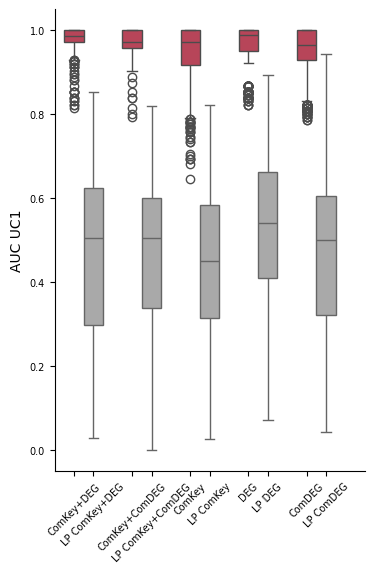

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


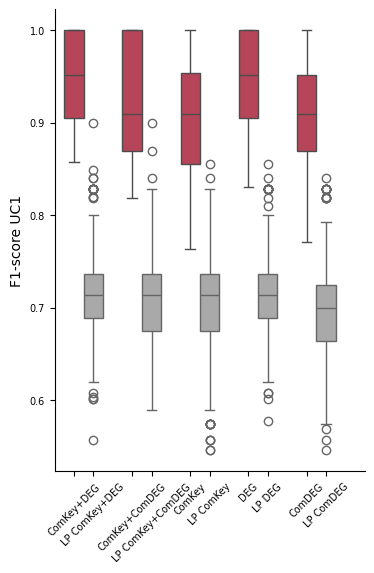

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


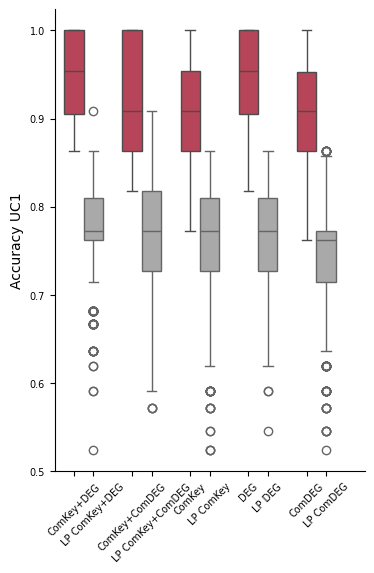

In [15]:
#### figure generation 
# aucs_data1 LB_aucs_data1
# f1score_data1 LB_f1score_data1
# accu_data1 LB_accu_data1

# boxplot_plot_func(aucs_data1, LB_aucs_data1, "AUC_1")
# boxplot_plot_func(f1score_data1, LB_f1score_data1, "f1_1")
# boxplot_plot_func(accu_data1, LB_accu_data1, "acc_1")

boxplot_plot_funcF(aucs_data1, LB_aucs_data1, "AUC UC1")
boxplot_plot_funcF(f1score_data1, LB_f1score_data1, "F1-score UC1")
boxplot_plot_funcF(accu_data1, LB_accu_data1, "Accuracy UC1")

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


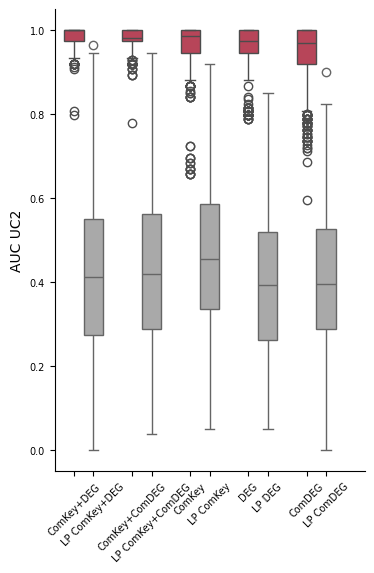

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


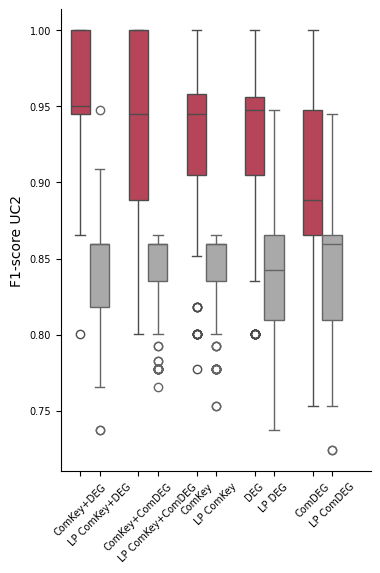

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


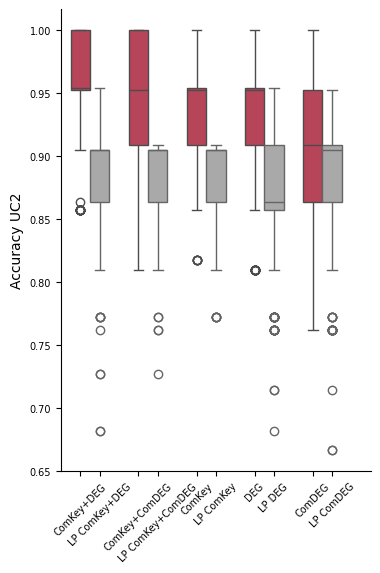

In [16]:
#### figure generation 
# aucs_data2 LB_aucs_data2
# f1score_data2 LB_f1score_data2
# accu_data2 LB_accu_data2

# boxplot_plot_func(aucs_data2, LB_aucs_data2, "AUC_2")
# boxplot_plot_func(f1score_data2, LB_f1score_data2, "f1_2")
# boxplot_plot_func(accu_data2, LB_accu_data2, "acc_2")

boxplot_plot_funcF(aucs_data2, LB_aucs_data2, "AUC UC2")
boxplot_plot_funcF(f1score_data2, LB_f1score_data2, "F1-score UC2")
boxplot_plot_funcF(accu_data2, LB_accu_data2, "Accuracy UC2")

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


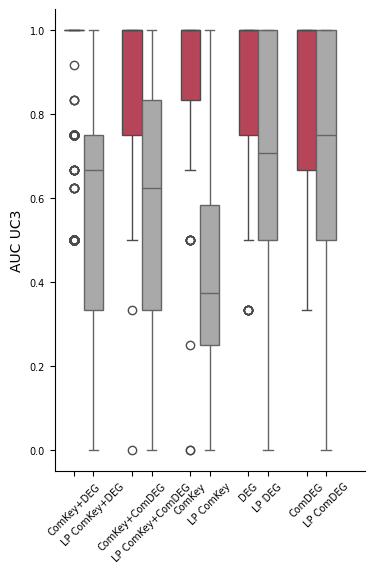

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


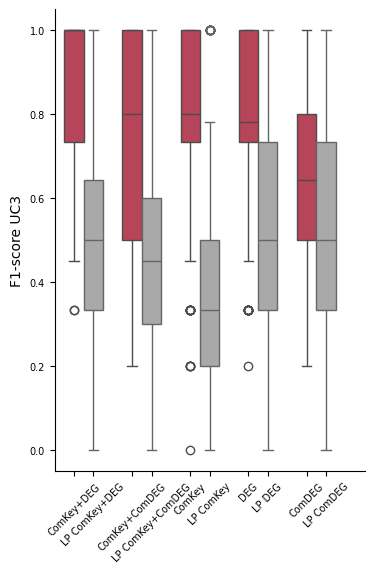

[0, 0.1, 0.3, 0.4, 0.6, 0.7, 0.9, 1.0, 1.2, 1.3]


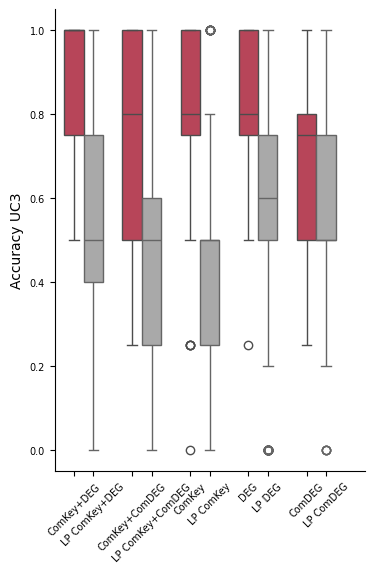

In [17]:
#### figure generation 
# aucs_data3 LB_aucs_data3
# f1score_data3 LB_f1score_data3
# accu_data3 LB_accu_data3

# boxplot_plot_func(aucs_data3, LB_aucs_data3, "AUC_3")
# boxplot_plot_func(f1score_data3, LB_f1score_data3, "f1_3")
# boxplot_plot_func(accu_data3, LB_accu_data3, "acc_3")

boxplot_plot_funcF(aucs_data3, LB_aucs_data3, "AUC UC3")
boxplot_plot_funcF(f1score_data3, LB_f1score_data3, "F1-score UC3")
boxplot_plot_funcF(accu_data3, LB_accu_data3, "Accuracy UC3")
